# RNA-Seq differential gene expression analysis in Mouse liver

In [1]:
library(dplyr)
library(reshape2)
library(tidyverse)
library(ggplot2)
library(DESeq2)
library(pheatmap)
library(clusterProfiler)
library(msigdbr)
library(ggplotify)
library(biomaRt)
library(org.Mm.eg.db)
library(ggrepel)
library(dendsort)
library(dendextend)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGe

In [2]:
counts.mat <- read.table(file = 'data/genecounts.mouse.csv',header = TRUE,sep = ',')


In [3]:
coldata <- read.table(file = 'data/coldata.mouse.csv',header = TRUE,sep = ',',row.names = 1) %>% 
mutate(condition = condition %>% factor(levels = c('C','T'),labels = c('Control','Treatment')))


In [4]:
dds.genes <- counts.mat %>% floor %>% 
DESeqDataSetFromMatrix(colData = coldata,design = ~condition) %>% 
estimateSizeFactors %>% estimateDispersions


converting counts to integer mode

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



In [5]:
dds.genes.nbinomwaldtest <- dds.genes %>% 
(function(.) {
    design(.) <- ~condition
    nbinomWaldTest(.)
})


In [6]:
ddr.genes.nbinomwaldtest.condition_treatment_vs_control <- dds.genes.nbinomwaldtest %>% 
results(contrast = c('condition','Treatment','Control'))


In [7]:
entrez_id.ensembl_id.symbol <- org.Mm.egENSEMBL %>% as.data.frame %>% 
mutate((org.Mm.egSYMBOL %>% as.data.frame %>% column_to_rownames('gene_id'))[gene_id,'symbol',drop = FALSE]) %>% 
merge(y=org.Mm.egCHR %>% as.data.frame,by = 'gene_id') %>% 
dplyr::rename(entrez_id = gene_id) %>% 
group_by(ensembl_id) %>% 
reframe(entrez_id = entrez_id %>% unique %>% paste(collapse = ';'),symbol = symbol %>% unique %>% paste(collapse = ';'),chromosome = chromosome %>% unique %>% paste(collapse = ';'))


ensembl_id,entrez_id,symbol,chromosome
<chr>,<chr>,<chr>,<chr>
ENSMUSG00000000001,14679,Gnai3,3
ENSMUSG00000000003,54192,Pbsn,X


In [8]:
ddr.genes.nbinomwaldtest.condition_treatment_vs_control.anno <- ddr.genes.nbinomwaldtest.condition_treatment_vs_control %>% data.frame %>% 
filter(baseMean >= 20) %>% 
rownames_to_column('ensembl_id') %>% 
mutate((entrez_id.ensembl_id.symbol %>% column_to_rownames('ensembl_id'))[ensembl_id,],.after = 1)


Warning message:
“Removed 79 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range (`geom_label_repel()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_label_repel()`).”


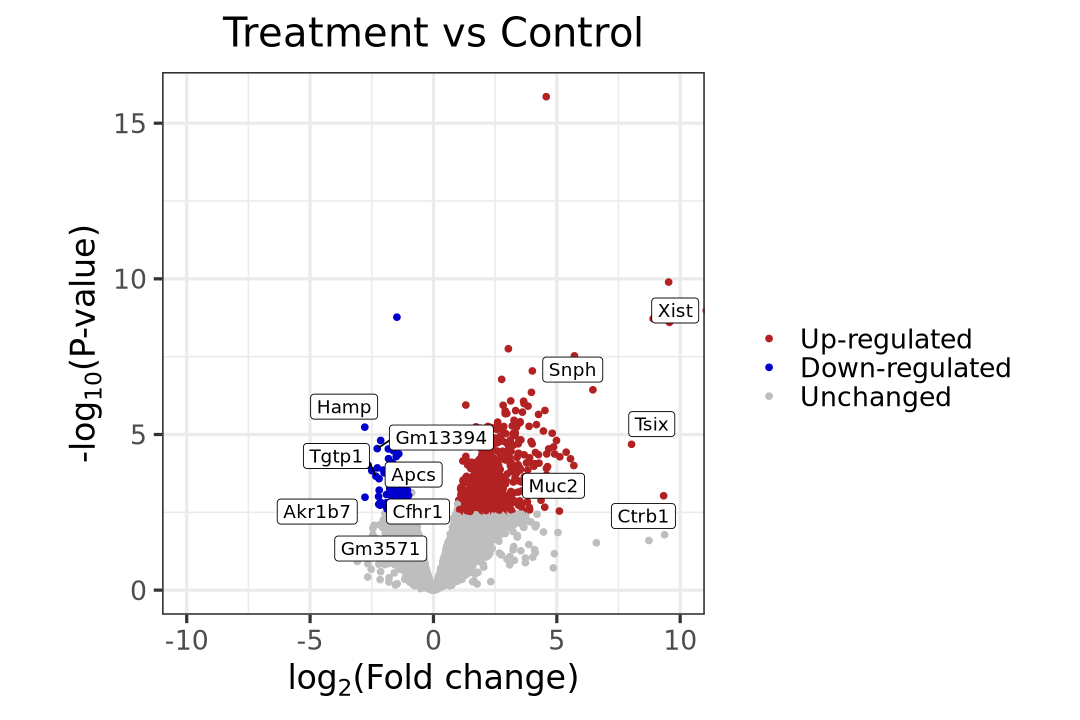

In [9]:
options(repr.plot.width = 9,repr.plot.height = 6)

ddr.genes.nbinomwaldtest.condition_treatment_vs_control.anno %>% 

(function(.) ggplot(.,mapping = aes(
    x = log2FoldChange,y = -log10(pvalue),
    col = case_when(
        log2FoldChange >= 1 & padj < .05 ~ 'Up-regulated',
        log2FoldChange <= -1 & padj < .05 ~ 'Down-regulated',
        .default = 'Unchanged'
    ) %>% factor(levels = c('Up-regulated','Down-regulated','Unchanged'))
)) +
geom_point() +
scale_color_manual(name = '',values = c('Up-regulated' = 'firebrick','Down-regulated' = 'mediumblue','Unchanged' = 'gray')) +

geom_label_repel(max.overlaps = 20,
    data = filter(.,log2FoldChange >= 1 & padj < .1) %>% arrange(-log2FoldChange) %>% head(n = 10),
    mapping = aes(label = symbol),col = 'black'
) +
geom_label_repel(max.overlaps = 20,
    data = filter(.,log2FoldChange <= -1 & padj < .1) %>% arrange(log2FoldChange) %>% head(n = 10),
    mapping = aes(label = symbol),col = 'black'
) +

labs(title = 'Treatment vs Control',x = expression('log'[2]*'(Fold change)'),y = expression('-log'[10]*'(P-value)')) +
coord_cartesian(xlim = c(-10,10)) +
theme_bw(base_size = 20) +
theme(plot.title = element_text(hjust = .5),aspect.ratio = 1)
)


In [10]:
ddr.genes.nbinomwaldtest.condition_treatment_vs_control.anno.gsego_bp <- ddr.genes.nbinomwaldtest.condition_treatment_vs_control.anno %>% 
filter(padj < .05) %>% 
with(log2FoldChange %>% setNames(nm = ensembl_id)) %>% sort(decreasing = TRUE) %>% 
gseGO(ont = 'bp',OrgDb = org.Mm.eg.db,keyType = 'ENSEMBL',pvalueCutoff = .1,nPermSimple = 10000)


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.35% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 10 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 100000)”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, 

In [11]:
ddr.genes.nbinomwaldtest.condition_treatment_vs_control.anno.gsego_bp %>% data.frame %>% 
filter(ID == 'GO:0035456')


,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0035456,GO:0035456,response to interferon-beta,14,-0.7690706,-3.514865,6.838483e-09,4.160677e-07,3.254436e-07,470,"tags=93%, list=20%, signal=74%",ENSMUSG00000026104/ENSMUSG00000029203/ENSMUSG00000040253/ENSMUSG00000078920/ENSMUSG00000078853/ENSMUSG00000020464/ENSMUSG00000032372/ENSMUSG00000058163/ENSMUSG00000054072/ENSMUSG00000034459/ENSMUSG00000069874/ENSMUSG00000078921/ENSMUSG00000078922


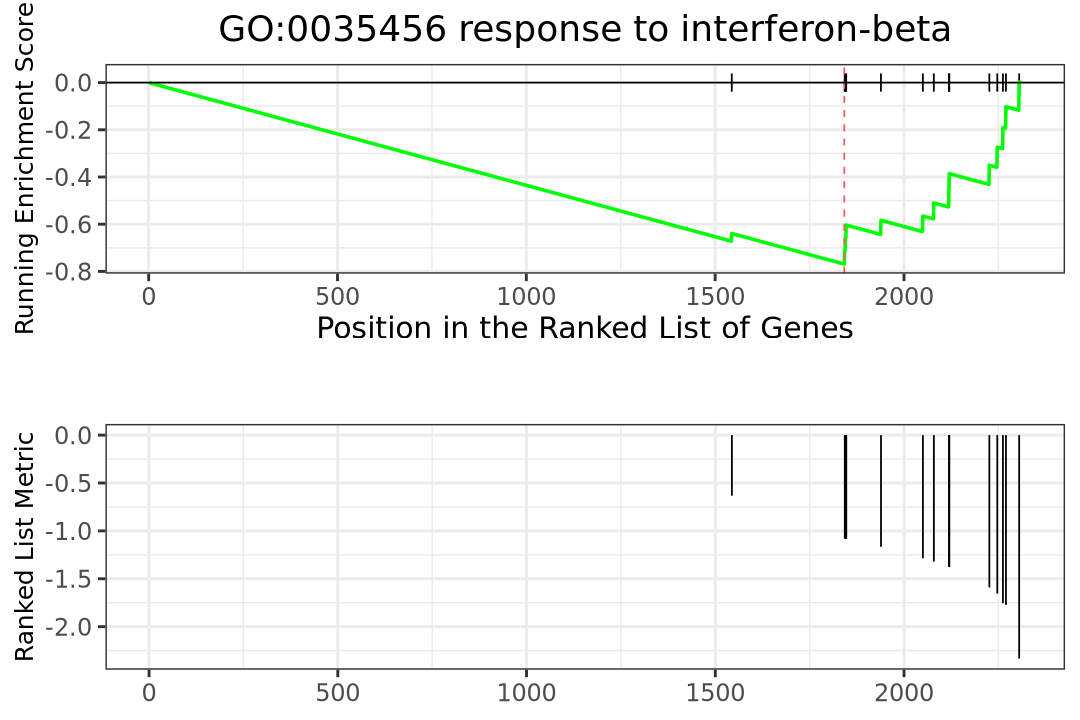

In [12]:
options(repr.plot.width = 9,repr.plot.height = 6)
library(gridExtra)

glist <- ddr.genes.nbinomwaldtest.condition_treatment_vs_control.anno.gsego_bp %>% 
gseaplot(geneSetID = 'GO:0035456')

g <- grid.arrange(
    glist[[2]] + labs(title = 'GO:0035456 response to interferon-beta') + theme_bw(base_size = 18) + theme(plot.title = element_text(hjust = .5),axis.title.y = element_text(size = 15)),
    glist[[1]] + theme_bw(base_size = 18) + theme(plot.title = element_text(hjust = .5),axis.title.y = element_text(size = 15)),
    ncol = 1
)


In [13]:
ddr.genes.nbinomwaldtest.condition_treatment_vs_control.anno.gsego_bp %>% 
setReadable(OrgDb = org.Mm.eg.db,keyType = 'ENSEMBL') %>% data.frame %>% 
filter(grepl('[iI]nterferon|[iI]mmune',Description))


,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0035456,GO:0035456,response to interferon-beta,14,-0.7690706,-3.477935,1.759320e-08,1.257914e-06,9.930899e-07,470,"tags=93%, list=20%, signal=74%",Stat1/Ube2k/Gbp7/Ifi47/Igtp/Pnpt1/Plscr2/Gm5431/Iigp1/Ifit1/Irgm2/Tgtp2/Tgtp1
GO:0035458,GO:0035458,cellular response to interferon-beta,13,-0.7662640,-3.294743,9.291474e-08,5.314723e-06,4.195834e-06,470,"tags=92%, list=20%, signal=74%",Stat1/Ube2k/Gbp7/Ifi47/Igtp/Pnpt1/Gm5431/Iigp1/Ifit1/Irgm2/Tgtp2/Tgtp1
GO:0002250,GO:0002250,adaptive immune response,99,0.3331520,1.593582,6.885331e-03,5.728596e-02,4.522576e-02,1342,"tags=85%, list=58%, signal=37%",Lat/Gimap3/Il18rap/Prr7/Txk/Foxj1/Cracr2a/Arid5a/Tbx21/Lax1/Trpm4/Lef1/Il2rb/Nfkbid/Fcamr/Prf1/Klhl6/Il7r/Itk/Anxa1/Ager/Clec4d/Cd28/Zap70/Trem2/Skap1/Zc3h12a/Nfkbiz/Nlrp3/Card9/Trem1/Ephb6/Gadd45g/Tnf/Spn/Cd3e/Eomes/Fut7/Cd24a/Clcf1/Il12rb1/H2-Eb1/Lat2/Cd8a/Ccl19/Myo1g/Inpp5d/Unc13d/Prkcq/Tnfaip3/Pik3cd/Il27ra/Adcy7/Rftn1/Ripk3/Batf/C1qb/Pkn1/Irf4/Sash3/Tnfsf13/Rab27a/Csf2rb2/Cd244a/Syk/Vsir/Prkcb/Crlf2/Hlx/Il4ra/C1qc/Pycard/Tgfb1/H2-DMa/Csf2rb/H2-DMb1/Gimap5/Cd44/Tnfrsf11a/Fyn/Nckap1l/Il20rb/Nod2/Il21r
GO:0140888,GO:0140888,interferon-mediated signaling pathway,11,-0.4565359,-1.825428,1.061793e-02,7.462867e-02,5.891737e-02,769,"tags=91%, list=33%, signal=61%",Oas1g/Ythdf3/Ifih1/Parp9/Stat1/Ube2k/Dnaja3/Rnf185/Igtp/Irgm2
GO:0002460,GO:0002460,adaptive immune response based on somatic recombination of immune receptors built from immunoglobulin superfamily domains,70,0.3402377,1.568450,1.324963e-02,8.736356e-02,6.897123e-02,1377,"tags=89%, list=60%, signal=37%",Gimap3/Il18rap/Foxj1/Cracr2a/Arid5a/Tbx21/Trpm4/Lef1/Il2rb/Nfkbid/Prf1/Klhl6/Il7r/Anxa1/Ager/Cd28/Trem2/Zc3h12a/Nfkbiz/Nlrp3/Card9/Ephb6/Gadd45g/Tnf/Spn/Fut7/Cd24a/Clcf1/Il12rb1/Cd8a/Ccl19/Myo1g/Inpp5d/Unc13d/Prkcq/Tnfaip3/Il27ra/Rftn1/Ripk3/Batf/C1qb/Pkn1/Irf4/Sash3/Tnfsf13/Rab27a/Csf2rb2/Vsir/Crlf2/Hlx/Il4ra/C1qc/Tgfb1/H2-DMa/Csf2rb/Gimap5/Nckap1l/Il20rb/Nod2/Il21r/C1qa/Jak3
GO:0002263,GO:0002263,cell activation involved in immune response,73,0.3450327,1.599173,1.502109e-02,9.441831e-02,7.454077e-02,1300,"tags=84%, list=56%, signal=38%",Lat/Pglyrp1/Il10/Cracr2a/Tbx21/Itgam/Lef1/Nfkbid/Mdk/Nkg7/Anxa1/Clec4d/Cd28/Cd177/Trem2/Myb/Zc3h12a/Nfkbiz/Rab44/Nlrp3/Gadd45g/Tnf/Spn/Eomes/Anxa3/Clcf1/Coro1a/Lat2/Adora2b/Ccl19/Pram1/H2-DMb2/Fes/Unc13d/Lfng/Tnfaip3/Il27ra/Mfng/Dysf/Batf/Ptger4/Irf4/Tnfsf13/Rab27a/Cd244a/Syk/Rac2/Dock2/Hlx/Sbno2/Il4ra/Pycard/Irf8/Itgb2/Tgfb1/Lgals3/Spi1/H2-DMb1/Itgal/Myo1f/Nckap1l
GO:0002366,GO:0002366,leukocyte activation involved in immune response,73,0.3450327,1.599173,1.502109e-02,9.441831e-02,7.454077e-02,1300,"tags=84%, list=56%, signal=38%",Lat/Pglyrp1/Il10/Cracr2a/Tbx21/Itgam/Lef1/Nfkbid/Mdk/Nkg7/Anxa1/Clec4d/Cd28/Cd177/Trem2/Myb/Zc3h12a/Nfkbiz/Rab44/Nlrp3/Gadd45g/Tnf/Spn/Eomes/Anxa3/Clcf1/Coro1a/Lat2/Adora2b/Ccl19/Pram1/H2-DMb2/Fes/Unc13d/Lfng/Tnfaip3/Il27ra/Mfng/Dysf/Batf/Ptger4/Irf4/Tnfsf13/Rab27a/Cd244a/Syk/Rac2/Dock2/Hlx/Sbno2/Il4ra/Pycard/Irf8/Itgb2/Tgfb1/Lgals3/Spi1/H2-DMb1/Itgal/Myo1f/Nckap1l


13



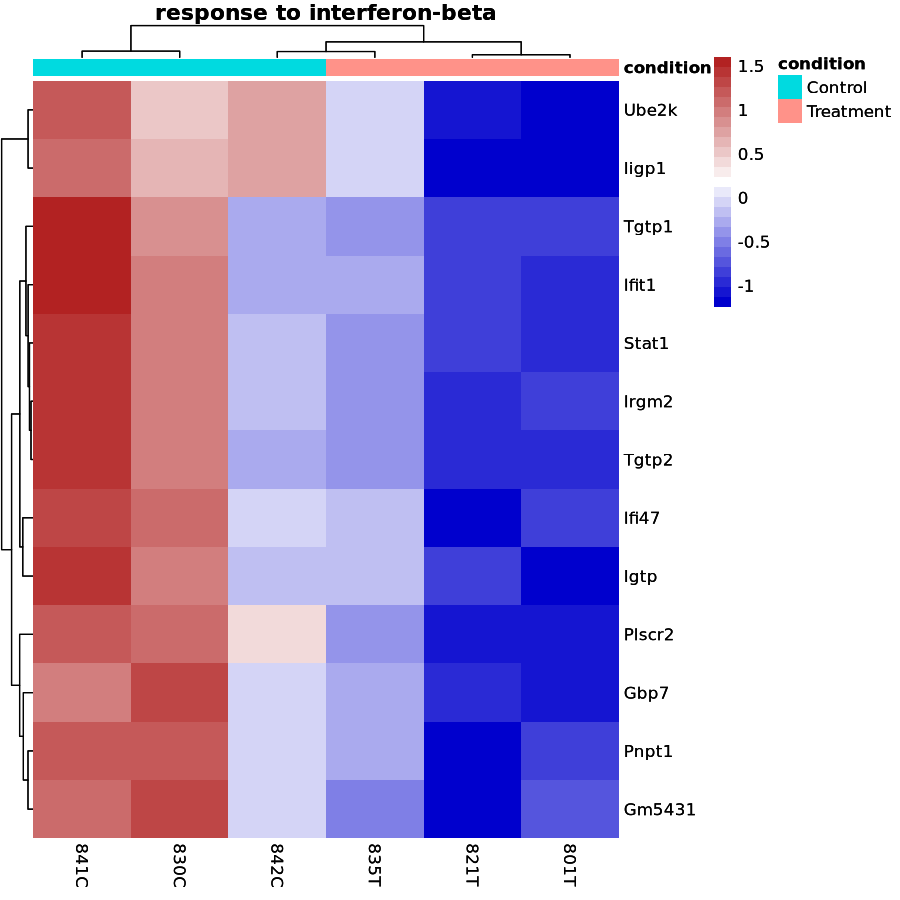

In [14]:
options(repr.plot.width = 7.5,repr.plot.height = 7.5)

g <- (dds.genes %>% counts(normalized = TRUE))[
#(vsd.genes_mouse %>% assay)[
    ddr.genes.nbinomwaldtest.condition_treatment_vs_control.anno.gsego_bp %>% 
    data.frame %>% 
    filter(ID == 'GO:0035456') %>% 
    with(core_enrichment) %>% 
    strsplit(split = '/') %>% 
    unlist
    ,
] %>% 
t %>% scale %>% t %>% 
(function(.) {
    nrow(.) %>% message
    
    myhclust.gene <- dist(.) %>% hclust %>% as.dendrogram %>% as.hclust
    myhclust.sample <- t(.) %>% dist %>% hclust %>% as.dendrogram %>% dendsort %>% rotate(order = 6:1) %>% as.hclust
    
    pheatmap(
        .,
        border_color = NA,
        main = 'response to interferon-beta',
        cluster_cols = myhclust.sample,
        cluster_rows = myhclust.gene,
        labels_row = (entrez_id.ensembl_id.symbol %>% column_to_rownames('ensembl_id'))[row.names(.),'symbol'],
        color = colorRampPalette(colors = c('mediumblue','white','firebrick'))(25),
        treeheight_row = 15,treeheight_col = 15,
        annotation_col = dds.genes@colData %>% data.frame %>% dplyr::select(condition)
    )
})

g


In [15]:
sessionInfo()


R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.4 (Ootpa)

Matrix products: default
BLAS/LAPACK: /home/users/nus/vincent2/micromamba/envs/R4.3-env/lib/libopenblasp-r0.3.26.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Singapore
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] dendextend_1.18.0           dendsort_0.3.4             
 [3] ggrepel_0.9.6               org.Mm.eg.db_3.18.0        
 [5] AnnotationDbi_1.64.1        biomaRt_2.58.2        